# 4.4.1 Phân cụm khách hàng dựa trên Tổng chi tiêu (Montage) và tần suất mua hàng (Frequency)

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from datetime import datetime

## Tiền xử lý dữ liệu và chuẩn hóa dữ liệu

In [40]:
# 1. Đọc dữ liệu
df = pd.read_excel("C:/Users/84967/Downloads/GIT CLONE HTTP/KPDL/Data/Online Retail.xlsx")

# Loại bỏ các hóa đơn hủy (các giá trị InvoiceNo bắt đầu bằng 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Tính toán cột Total: Số lượng * Đơn giá
df['Total'] = df['Quantity'] * df['UnitPrice']

# 2. Tổng hợp dữ liệu theo khách hàng
# Ví dụ: Tính Tổng chi tiêu (Monetary) và Số lần giao dịch (Frequency)
# Ngoài ra, bạn có thể tính thêm Recency nếu cần.
customer_agg = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Total': 'sum',
    'InvoiceDate': 'max'
}).reset_index()

customer_agg.rename(columns={'InvoiceNo': 'Frequency', 'Total': 'Monetary'}, inplace=True)

# Tính Recency: số ngày từ lần mua cuối đến một ngày chuẩn (giả sử là ngày cuối của dữ liệu)
customer_agg['InvoiceDate'] = pd.to_datetime(customer_agg['InvoiceDate'])
reference_date = customer_agg['InvoiceDate'].max()
customer_agg['Recency'] = (reference_date - customer_agg['InvoiceDate']).dt.days

print(customer_agg.info())
print(customer_agg.head())

# Chọn các đặc trưng để phân cụm, ví dụ: Monetary và Frequency
# Bạn có thể thay đổi các đặc trưng này theo mục đích phân tích
X = customer_agg[['Monetary', 'Frequency']]

# 3. Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   4339 non-null   float64       
 1   Frequency    4339 non-null   int64         
 2   Monetary     4339 non-null   float64       
 3   InvoiceDate  4339 non-null   datetime64[ns]
 4   Recency      4339 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 169.6 KB
None
   CustomerID  Frequency  Monetary         InvoiceDate  Recency
0     12346.0          1  77183.60 2011-01-18 10:01:00      325
1     12347.0          7   4310.00 2011-12-07 15:52:00        1
2     12348.0          4   1797.24 2011-09-25 13:13:00       74
3     12349.0          1   1757.55 2011-11-21 09:51:00       18
4     12350.0          1    334.40 2011-02-02 16:01:00      309


## Vẽ K-distance và xác định điểm gãy

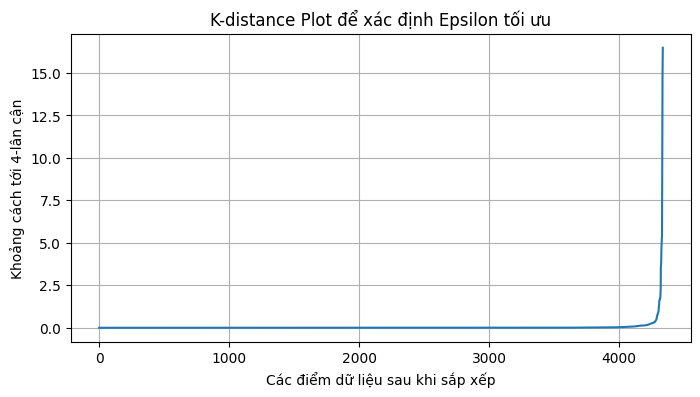

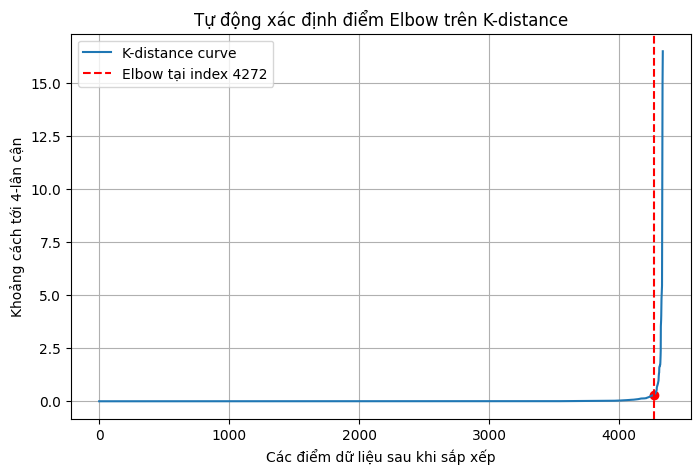

✅ Giá trị Epsilon tối ưu được xác định là: 0.31


In [34]:
# 4. Xác định tham số epsilon bằng K-distance plot
k = 4  # MinPts = 4 (2 * số chiều = 2*2 nếu dùng 2 đặc trưng)
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title("K-distance Plot để xác định Epsilon tối ưu")
plt.xlabel("Các điểm dữ liệu sau khi sắp xếp")
plt.ylabel(f"Khoảng cách tới {k}-lân cận")
plt.grid(True)
plt.show()

# Tìm điểm gãy (Elbow) bằng cách tính khoảng cách từ mỗi điểm đến đường thẳng nối đầu-cuối
x_vals = np.arange(len(k_distances))
start_point = np.array([x_vals[0], k_distances[0]])
end_point = np.array([x_vals[-1], k_distances[-1]])
line_vec = end_point - start_point
line_vec_norm = line_vec / np.linalg.norm(line_vec)
vec_from_start = np.column_stack((x_vals, k_distances)) - start_point
scalar_proj = np.dot(vec_from_start, line_vec_norm)
proj = np.outer(scalar_proj, line_vec_norm)
vec_to_line = vec_from_start - proj
dist_to_line = np.linalg.norm(vec_to_line, axis=1)
elbow_index = np.argmax(dist_to_line)
optimal_eps = k_distances[elbow_index]

plt.figure(figsize=(8, 5))
plt.plot(k_distances, label="K-distance curve")
plt.axvline(elbow_index, color='r', linestyle='--', label=f"Elbow tại index {elbow_index}")
plt.scatter(elbow_index, optimal_eps, color='red')
plt.title("Tự động xác định điểm Elbow trên K-distance")
plt.xlabel("Các điểm dữ liệu sau khi sắp xếp")
plt.ylabel(f"Khoảng cách tới {k}-lân cận")
plt.legend()
plt.grid(True)
plt.show()

print(f"✅ Giá trị Epsilon tối ưu được xác định là: {round(optimal_eps, 3)}")

## Huấn luyện mô hình

In [35]:
# 5. Áp dụng DBSCAN với Epsilon (bạn có thể điều chỉnh eps theo kết quả từ đồ thị)
dbscan_model = DBSCAN(eps=optimal_eps, min_samples=k).fit(X_scaled)

# Gán nhãn cụm vào DataFrame
customer_agg['Cluster'] = dbscan_model.labels_

# Kiểm tra thông tin mô hình
dbscan_model

DBSCAN(eps=np.float64(0.30993468792001894), min_samples=4)

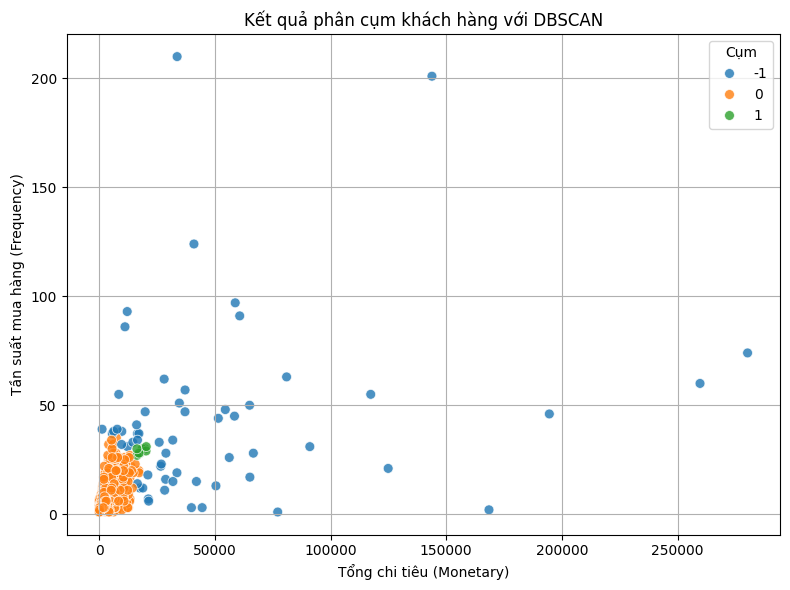

In [36]:
# 6. Trực quan hóa kết quả phân cụm (sử dụng hai đặc trưng: Monetary và Frequency)
plt.figure(figsize=(8, 6))
palette = sns.color_palette('tab10', n_colors=len(customer_agg['Cluster'].unique()))
sns.scatterplot(
    data=customer_agg,
    x='Monetary',
    y='Frequency',
    hue='Cluster',
    palette=palette,
    s=50,
    alpha=0.8
)
plt.title("Kết quả phân cụm khách hàng với DBSCAN")
plt.xlabel("Tổng chi tiêu (Monetary)")
plt.ylabel("Tần suất mua hàng (Frequency)")
plt.legend(title='Cụm')
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# 7. Tính Silhouette Score (loại bỏ các điểm nhiễu với nhãn -1)
labels = dbscan_model.labels_
mask = labels != -1
if len(set(labels[mask])) > 1:
    score = silhouette_score(X_scaled[mask], labels[mask])
    print(f"Silhouette Score: {score:.3f}")
else:
    print("⚠️ Không đủ cụm hợp lệ để tính Silhouette Score.")


Silhouette Score: 0.843


# 4.4.2 Phân cụm khách hàng dựa trên Tổng chi tiêu (Montage) và Số ngày giao dịch cuối cùng (Recency)

# 4.4.3 Phân cụm khách hàng dựa trên tần suất mua hàng (Frequency) và Số ngày giao dịch cuối cùng (Recency)